# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on El Nino prediction

<i> Balázs Kégl (CNRS), Claire Monteleoni (GWU), Mahesh Mohan (GWU), Timothy DelSole (COLA), Kathleen Pegion (COLA), Julie Leloup (UPMC), Alex Gramfort (LTCI), Mehdi Cherti (CNRS), Camille Marini (CNRS) </i>

<h2>Introduction</h2>

A climate index is real-valued time-series which has been designated of interest in the climate literature. For example, the El Niño–Southern Oscillation (ENSO) index has widespread uses for predictions of regional and seasonal conditions, as it tends to have strong (positive or negative) correlation with a variety of weather conditions and <a href=http://www.ipcc-wg2.gov/SREX/images/uploads/SREX-SPMbrochure_FINAL.pdf>extreme events</a> throughout the globe. The ENSO index is just one of the many climate indices studied. However there is currently significant room for improvement in predicting even this extremely well studied index with such high global impact. For example, most statistical and climatological models erred significantly in their predictions of the 2015 El Niño event; their predictions were off by several months. Better tools to predict such indices are critical for seasonal and regional climate prediction, and would thus address grand challenges in the study of climate change (<a href=https://www.wcrp-climate.org/grand-challenges/grand-challenges-overview>World Climate Research Programme: Grand Challenges, 2013)</a>.

<h3>El Niño</h3>

<a href="https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php">El Niño</a> (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of $+0.5^\circ$C ($-0.5\circ$C). This standard of measure is known as the Oceanic Niño Index (ONI).

<img src="https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif">

More information can be found <a href=https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php>here</a> on why it is an important region, and what the history of the index is.

Here are the <a href = http://iri.columbia.edu/our-expertise/climate/forecasts/enso/current/>current ENSO predictions</a>, updated monthly.


<h3>The CCSM4 simulator</h3>

Our data is coming from the <a href=http://www.cesm.ucar.edu/models/ccsm4.0/>CCSM4.0</a> model (simulator). This allows us to access a full regular temperature map for a 500+ year period which makes the evaluation of the predictor more robust than if we used real measurements. 

<h3>The data</h3>

The data is a time series of "images" $z_t$, consisting of temperature measurements (for a technical reason it is not SST that we will work with, rather air temperature) on a regular grid on the Earth, indexed by lon(gitude) and lat(itude) coordinates. Latitude and longitude are sampled at a resolution of $5^\circ$, giving 37 latitude and 72 longitude grid points, 2664 temperature measurements at every time step. The average temperatures are recorded every month for 119 years, giving 1428 time points in the public training data (available in the starting kit), 155/1860 in the training data (public leaderboard), and 500/6000 in the test data (private leaderboard). The goal is to predict the average temperature in the El Niño region, <span style="color:red">6 months ahead</span>.

Note that the data set given in the starting kit is different from the one used to evaluate your submissions (of course, the data <i>structures</i> and the generative model (simulator) will be identical), so your submission should be generic (for example, it should be able to handle a time series of different length). 

<h3>The prediction task</h3>

The pipeline consists of a feature extractor and a predictor. Since the task is regression, the predictor will be a regressor, and the score (to minimize) will be the <a href=http://en.wikipedia.org/wiki/Root-mean-square_deviation>root mean square error</a>. The feature extractor will have access to the whole data. It will construct a "classical" feature matrix where each row corresponds to a time point. You should collect all information into these features that you find relevant to the regressor. The feature extractor can take <span style="color:red">anything from the past</span>, that is, it will implement a function $x_t = f(z_1, \ldots, z_t)$. Since you will have access to the full data, in theory you can cheat (even inadvertantly) by using information from the future. We have implemented a randomized test to detect such submissions, but please do your best to avoid this since it would make the results irrelevant.

<h3>Domain-knowledge suggestions</h3>

You are of course free to explore any regression technique to improve the prediction. Since the input dimension is relatively large (2000+ dimensions per time point even after subsampling) sparse regression techniques (eg. LASSO) may be the best way to go, but this is just an a priori suggestion. The following list provides you other hints to start with, based on domain knowledge. 
<ul>
<li>There is a strong seasonal cycle that must be taken into account.
<li>There is little scientific/observational evidence that regions outside the Pacific play a role in NINO3.4 variability, so it is probably best to focus on Pacific SST for predictions.  
<li>The relation between tropical and extra-tropical Pacific SST is very unclear, so please explore!
<li>The NINO3.4 index has an oscillatory character (cold followed by warm followed by cold), but this pattern does not repeat exactly.  It would be useful to be able to predict periods when the oscillation is “strong” and when it “breaks down.”  
<li>A common shortcoming of empirical predictions is that they under-predict the <i>amplitude</i> of warm and cold events.  Can this be improved?
<li>There is evidence that the predictability is low when forecasts start in, or cross over, March and April (the so-called “spring barrier”). Improving predictions through the spring barrier would be important.
<ul>

# Exploratory data analysis

Packages to install:

<code>conda install xarray dask netCDF4 bottleneck basemap</code><BR>

In [3]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Let's start by reading the data into an xray Dataset object. You can find all information on how to access and manipulate <code>Dataset</code> and <code>DataArray</code> objects at the <a href=http://xray.readthedocs.org/en/stable/>xarray site</a>.

In [4]:
X_ds = xr.open_dataset('el_nino_X_public_train.nc')
y_array = np.load('el_nino_y_public_train.npy')

Printing it, you can see that it contains all the data, indices, and other metadata.

In [5]:
X_ds

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 72, time: 1428)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
Data variables:
    tas      (time, lat, lon) float64 246.0 246.9 245.9 246.8 246.8 246.3 ...
Attributes:
    n_burn_in: 120
    n_lookahead: 6

y_array on the disk is already shifted by n_lookahead = 6 months. n-burnin = 120 (months) is the length of the prefix for which no prediction is required. If your feature extractor only uses these ten years of the past to extract features from, you don't need to worry about missing data in the beginning of the sequence. Otherwise you should take care of the issue "manually".

In [6]:
y_array, y_array.shape

(array([ 299.68909098,  299.62266947,  299.38398844, ...,  298.96761678,
         299.55478312,  299.60300395]), (1428,))

The main data is in the 'tas' ("temperature at surface") DataArray.

In [7]:
X_ds['tas']

<xarray.DataArray 'tas' (time: 1428, lat: 37, lon: 72)>
[3804192 values with dtype=float64]
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...

You can index it in the same way as a <code>pandas</code> or <code>numpy</code> array. The result is always a <coda>DataArray</code>

In [8]:
t = 123
lat = 13
lon = 29
X_ds['tas'][t]
X_ds['tas'][t, lat]
X_ds['tas'][t, lat, lon]
X_ds['tas'][:, lat, lon]
X_ds['tas'][t, :, lon]
X_ds['tas'][:, :, lon]

<xarray.DataArray 'tas' (time: 1428, lat: 37)>
array([[ 246.34985352,  253.71881104,  256.89190674, ...,  244.21122742,
         239.45343018,  237.40930176],
       [ 235.5670166 ,  243.0508728 ,  245.73396301, ...,  233.93948364,
         236.7585144 ,  236.36204529],
       [ 220.1075592 ,  228.37557983,  230.78536987, ...,  238.11174011,
         235.22380066,  234.21894836],
       ..., 
       [ 220.79437256,  232.26931763,  231.0856781 , ...,  246.27235413,
         246.00021362,  247.02697754],
       [ 230.71813965,  239.49308777,  242.3021698 , ...,  247.43449402,
         244.58831787,  241.91397095],
       [ 241.24087524,  247.70802307,  251.32254028, ...,  240.62811279,
         240.686203  ,  239.90797424]])
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
    lon      float64 147.5
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...

You can convert any of these objects into a <code>numpy</code> array.

In [9]:
X_ds['tas'].values
X_ds['tas'][t].values
X_ds['tas'][t, lat].values
X_ds['tas'][t, lat, lon].values

array(293.3496398925781)

You can also use slices, and slice bounds don't even have to be in the index arrays. The following function computes the target at time $t$. The input is a DataArray (3D panel) that contains the temperatures. We select the El Niño 3.4 region and take the mean temperatures, specifying that we are taking the mean over the spatial (lat and lon) coordinates. The output is a vector with the same length as the original time series.

In [10]:
en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

The following function plots the temperatures at a given $t$ (time_index). 

In [11]:
el_nino_lats = [en_lat_bottom, en_lat_top, en_lat_top, en_lat_bottom]
el_nino_lons = [en_lon_right, en_lon_right, en_lon_left, en_lon_left]

from matplotlib.patches import Polygon

def plot_map(X_ds, time_index):
    def draw_screen_poly(lats, lons, m):
        x, y = m(lons, lats)
        xy = list(zip(x, y))
        poly = Polygon(xy, edgecolor='black', fill=False)
        plt.gca().add_patch(poly)

    lons, lats = np.meshgrid(X_ds['lon'], X_ds['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    im = map.pcolormesh(
        lons, lats, X_ds[time_index] - 273.15, shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")
    draw_screen_poly(el_nino_lats, el_nino_lons, map)

    time_str = str(pd.to_datetime(str(X_ds['time'].values[time_index])))[:7]
    ax.set_title("Temperature map " + time_str)
    #plt.savefig("test_plot.pdf")
    plt.show()

Let's plot the temperature at a given time point. Feel free to change the time, play with the season, discover visually the variability of the temperature map. 

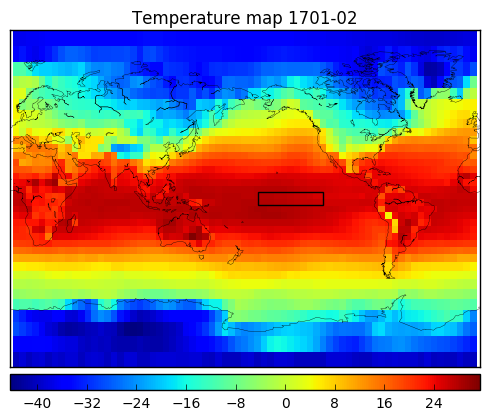

In [12]:
t = 13
plot_map(X_ds['tas'], t)

## The target

The goal is to predict the temperature in the El Niño region, $\ell = 6$ months ahead

\begin{equation}
  y_t = \frac{1}{D} \sum_{(lat, lon) \in \cal{A}_{\rm{El\ Niño}}} z_{t + \ell}^{(lat, lon)}
\end{equation}

Where $\cal{A}_{\rm{El\ Niño}} = \{(lat, lon) : -5^\circ < lat < 5^\circ \wedge -170^\circ < lon < -120^\circ\}$ is the index set of the El Niño 3.4 region, $D$ is the number of temperature measurements in the region, and $z_t^{(lat, lon)}$ is the temperature measured at time $t$, longitude $lon$ and latitude $lat$. 

The first order variation of the temperature comes from its regular yearly fluctuation. Climate scientists usually look at the temperture <i>anomaly</i>, not the raw temperature itself. More precisely, they subtract the montly average from the temperature. We set up the RAMP to predict the raw temperature because 1) subtracting the montly average is equivalent to adding the monthly average as an input feature to the regressor 2) we wanted to avoid computing the average on the full data since it would have violated causality (remember: you are not allowed to use the future, not even for computing averages). Nevertheless, it is interesting to look at the anomaly since you can compare it to plots produced by climate scientists.

The snippet also shows some powerful features of xarray (grouping by months, taking the groupby mean).

In [13]:
enso = get_enso_mean(X_ds['tas'])
enso_anomaly = enso.groupby('time.month') - enso.groupby('time.month').mean(dim='time')

We plot the anomaly in a five year period. Conventionally, the El Niño/La Niña threshold is $0.5^\circ$ Celsius. The plot displays the warm periods as red (El Niño) and cold perids (La Nina) as blue. To be precise, El Nino requires a period of three consecutive months with mean temperatures $0.5^\circ$ Celsius above the seasonal average, so not all colored periods qualify.

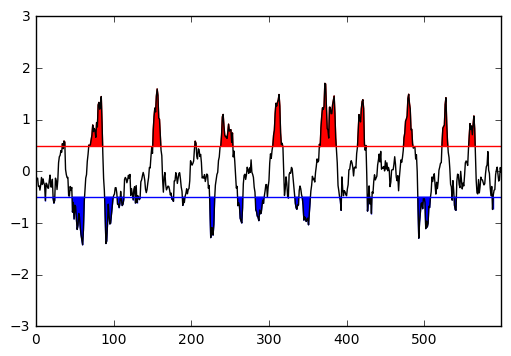

In [14]:
plt.clf()
xrange = np.arange(0, 600)
y = enso_anomaly[600:1200]
x_limits = [min(xrange), max(xrange)]
y_limits = [-3.0, 3.0]
el_nino_threshold = 0.5
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.plot(xrange, y, c='black')
plt.plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plt.plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
plt.fill_between(xrange, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True)
plt.fill_between(xrange, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold)
plt.savefig("anomaly.png")

## The cross-validation object

Cross validating time-series predictors is tricky. We can't simply shuffle the observations $z_t =$ <code>X_ds['tas'][t]</code> since we would lose both causality and the correlation structure that follows natural order. 

To formalize the issue, let us first define formally the predictor that we will produce in the RAMP. Let the time series be $z_1, \ldots, z_T$ and the let target to predict at time $t$ be $y_t$. The target is usually (and in our case) a function of the future $z_{t+1}, \ldots$, but it can be anything else. We want to learn a function that predicts $y$ from the past, that is

\begin{equation}
\hat{y}_t = f(z_1, ..., z_t) = f(Z_t)
\end{equation}

where $Z_t = (z_1, ..., z_t)$ is the past. Now, the sample $(Z_t, y_t)$ is a regular (although none iid) sample from the point of view of shuffling, so we can train on $\{Z_t, y_t\}_{t \in \cal{I}_{\text{train}}}$ and test on $(Z_t, y_t)_{t \in \cal{I}_{\text{test}}}$, where $\cal{I}_{\text{train}}$ and $\cal{I}_{\text{test}}$ are arbitrary but disjunct train and test index sets, respectively (typically produced by sklearn's <code>ShuffleSplit</code>). Using shuffling would nevertheless allow a second order leakage from training points to test points that preceed them, by, e.g., aggregating the training set and adding the aggregate back as a feature. To avoid this, we use block-CV: on each fold, all $t \in \cal{I}_{\text{test}}$ is larger than all $t \in \cal{I}_{\text{train}}$. We also make sure that all training and test sets contain consecutive observations, so recurrent nets and similar predictors, which rely on this, may be trained.

The training algorithm thus maps $(Z_t, y_t)_{t \in \cal{I}_{\text{train}}}$ to $f$. The point $Z_t$ contains the target for all training points $Z_{t'}$ for $t' \le t - 6$, so it is technically possible to cheat: when you receive a test set $z_1, ..., z_T$, you could look up the target of $z_t$ in $z_{t+6}$. To detect this (often inadvertant) cheating, we will check that you feature extractor is invariant to the future. 

To allow a reasonably long past before making the first prediction, we strip the first $b = 120$ months (burn-in). You can of course use a longer window in your feature extractor, but in this case you will have to handle the missing time points in the beginning of the sequence.

## The pipeline

We have factorized the pipeline into two steps. The first feature extractor $g$ transforms the past into a classical feature vector $x_t = g(Z_t)$, and the classical regressor $h$ predicts the target from the feature vector $\hat{y}_t = h(x_t)$. To summarize, the full predictor is a composition $f(Z_t) = h(g(Z_t))$. If you have a complex solution where this factorization does not make sense, you can do all the work in the feature extractor, output a prediction $x_t$ into a single-column feature matrix, and then use an identity regressor $\hat{y}_t = x_t$ in the regressor module. 

### The feature extractor

The feature extractor implements a single <code>transform</code> function. As we explained above, it receives the full <code>X_ds</code> including the burn-in period $b$ as an attribute. It should produce a feature matrix of length $T - b$, type numpy array, representing the past vector $(Z_{t+b}, \ldots, Z_{T})$. For constructing/computing $x_t$, it can only use the past $Z_t = (z_1, \ldots, z_t) = $ <code>X_ds['tas'][:t]</code>.

You can choose one of the example feature extractors and copy-paste it into your ts_feature_extractor.py file. Comments within the cells explain what they do. 

In [15]:
import numpy as np
import xarray as xr

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino mean at time t - (12 - X_ds.n_lookahead),
        corresponding the month to be predicted."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        enso = get_enso_mean(X_ds['tas'])
        # Roll the input series back so it corresponds to the month to be
        # predicted
        enso_rolled = np.roll(enso, 12 - X_ds.n_lookahead)
        # Strip burn in.
        enso_valid = enso_rolled[valid_range]
        # Reshape into a matrix of one column
        X_array = enso_valid.reshape((-1, 1))
        return X_array

In [16]:
import numpy as np
import xarray as xr

class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the whole field at time t."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        # Take the whole temperature field.
        all = X_ds['tas'].values
        # Vectorize it to obtain a single feature vector at time t.
        vectorized = all.reshape(len(all), -1)
        # Strip burn-in.
        X_array = vectorized[valid_range]
        return X_array

In [17]:
import numpy as np
import xarray as xr

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino running mean at time t - (12 - X_ds.n_lookahead),
        corresponding the month to be predicted."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        ensos = [
            get_enso_mean(X_ds['tas'].isel(time=slice(None, t)))
            for t in range(X_ds.n_burn_in, len(X_ds['tas']))]
        enso_anomalys = np.array([
            enso.groupby('time.month') - enso.groupby('time.month').mean(dim='time')
            for enso in ensos])
        X_array = enso_anomalys.reshape((-1, 1))
        print(valid_range.shape, len(ensos), len(X_ds['tas']), X_array.shape)
        return X_array

In [18]:
import numpy as np
import xarray as xr

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino running mean at time t - (12 - X_ds.n_lookahead),
        corresponding the month to be predicted and the anomaly at time t
        (the difference between the temperature and the monthly running meam
        
        The code is short but inefficient. We will we giving bonus points for short
        (elegant) and efficient solutions."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        enso = get_enso_mean(X_ds['tas'])
        # The running mean at time t. It is using xarray's groupby at every t, so
        # its running time is O(T^2). In principle it can be computed in O(T).
        enso_means = np.array([
            enso.isel(time=slice(None, t)).groupby('time.month').mean(dim='time')[t % 12]
            for t in range(X_ds.n_burn_in, len(X_ds['tas']))])
        # The temperatur anomaly
        enso_anomalys = enso[X_ds.n_burn_in:] - enso_means
        # Means (rolled to match the month to be predicted) and the anomalies concatenated.
        X_array = np.array([np.roll(enso_means, 12 - X_ds.n_lookahead), enso_anomalys.values]).T
        return X_array

## The illegal lookahead check

Since the feature extractor receives the full data series which contains the target, we have no technical constraints against cheating, that is, using information coming after the present (six months before the target). We can nevertheless check wether the feature $x_t$ changes if we alter the future $(z_{t+1}, \ldots)$. Such check is implemented both in the unit test (so you can check if your submission is valid) and at our backend (so you will receive a similar error message on the leaderboard if your model doesn't pass the test).

Of course, you have no reason to deliberately cheat, but it is possible that you accidentally introduce a bug. For example, the code below rolls the features in the wrong way (forward instead of backward):<br>
<code>enso_rolled = np.roll(enso, -X_ds.n_lookahead)</code>

Check what happens when the unit test is run.

In [19]:
import numpy as np
import xarray as xr

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino mean at time t - (12 - X_ds.n_lookahead),
        corresponding the month to be predicted."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        enso = get_enso_mean(X_ds['tas'])
        # Roll the input series forward ("by accident" :)) so it uses the
        # target as input.
        enso_rolled = np.roll(enso, -X_ds.n_lookahead)
        # Strip burn in.
        enso_valid = enso_rolled[valid_range]
        # Reshape into a matrix of one column
        X_array = enso_valid.reshape((-1, 1))
        return X_array

### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions. Let's start with two simple regressors, a linear regressor and a regression tree. You can copy paste either of these into your first regressor.py file.

In [20]:
from sklearn.base import BaseEstimator
from sklearn import linear_model
 
class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = linear_model.BayesianRidge()
 
    def fit(self, X, y):
        self.clf.fit(X, y)
 
    def predict(self, X):
        return self.clf.predict(X)

In [21]:
from sklearn.base import BaseEstimator
from sklearn import linear_model
 
class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = linear_model.Lasso(alpha=0.1)
 
    def fit(self, X, y):
        self.clf.fit(X, y)
 
    def predict(self, X):
        return self.clf.predict(X)

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = DecisionTreeRegressor(max_depth=5)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

### Unit test

You should use this notebook for preliminary analysis and visualization. Before submitting, you should make sure the code has no errors. First, copy-paste your regressor and feature extractor into the files <code>regressor.py</code> and <code>ts_feature_extractor.py</code>. Then execute the user_test_submission code, either in a separate terminal or below. You can also look at <code>user_test_submission.py</code> to see how we cross-validate and score your submissions. But don't modify it: its goal is to mimic what we do at our backend.

In [23]:
!python user_test_submission.py

length of training array: 576 months = 48 years
length of test array: 852 months = 71 years
length of burn in: 120 months = 10 years
length of common block: 168 months = 14 years
length of validation block: 288 months = 24 years
length of each cv block: 36 months = 3 years
train RMSE = 1.047; valid RMSE = 0.841; test RMSE = 0.757
train RMSE = 1.011; valid RMSE = 0.839; test RMSE = 0.75
train RMSE = 0.974; valid RMSE = 0.855; test RMSE = 0.751
train RMSE = 0.934; valid RMSE = 0.899; test RMSE = 0.749
train RMSE = 0.948; valid RMSE = 0.858; test RMSE = 0.754
train RMSE = 0.938; valid RMSE = 0.86; test RMSE = 0.751
train RMSE = 0.902; valid RMSE = 1.007; test RMSE = 0.751
train RMSE = 0.89; valid RMSE = 1.216; test RMSE = 0.751
mean train RMSE = 0.956 ± 0.0496
mean valid RMSE = 0.922 ± 0.1224
mean test RMSE = 0.752 ± 0.0024
